# <span style="color:green"><center>Diplomado en Inteligencia Artificial y Aprendizaje Profundo</center></span>

# <span style="color:red"><center>Eliminación de Ruido: Ejemplo MNIST</center></span>

##   <span style="color:blue">Profesores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Campo Elías Pardo Turriago, cepardot@unal.edu.co 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Asistentes</span>

5. Oleg Jarma, ojarmam@unal.edu.co 
6. Laura Lizarazo, ljlizarazore@unal.edu.co 

## <span style="color:blue">Contenido</span> 

* [Introducción](#Introducción)
* [Autocodificador o autoencoder](#Autocodificador-o-autoencoder)
* [Importa módulos](#Importa-módulos)
* [Descargar Datos de la Fuente](#Descargar-Datos-de-la-Fuente)
* [Parámetros de la red](#Parámetros-de-la-red)
* [Codificador](#Codificador)
* [Decodificador](#Decodificador)
* [Auto-codificador](#Auto-codificador)
* [Entrenamiento](#Compila)
* [Recuperación de imágenes](#Recuperación-de-imágenes)
* [Representación latente](#Representación-latente)

[[Volver al Inicio]](#Contenido)

## <span style="color:blue">Introducción</span>

En este cuaderno se implementa un Autoencoder Convolucional para la eliminación de ruido usando el conjunto de datos MNIST.

Basado en 

- [Convolutional Autoencoders for Image Noise Reduction](https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763)

- [Convolutional Autoencoder For Image Denoising](https://keras.io/examples/vision/autoencoder/) 

[[Volver al Inicio]](#Contenido)

## <span style="color:blue">Autocodificador o autoencoder</span>

Recordemos un poco el concepto gráfico de lo que significa un autoenconder:

![CAE](https://miro.medium.com/max/2400/1*VYH3i2-2CZ6Fyd7Bv9UHFw.png)

Fuente: [Super-Resolution Using Autoencoders and TF2.0](https://medium.com/analytics-vidhya/super-resolution-using-autoencoders-and-tf2-0-505215c1674)

## <span style="color:blue">Importa módulos</span>

In [1]:
#importar open cv                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ii!conda install -c conda-forge opencv
import cv2
# import tarfile para manejo de archivos comprimidos
import zipfile
# Manejo de gráficos
import matplotlib.pyplot as plt
#Manejo de carpetas
import os
# Manejo de Arreglos
import numpy as np
# Descomprimir .gz
import gzip
# Módulos especificos de tensorflow
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [2]:
np.set_printoptions(linewidth=125)

## <span style="color:blue">Descargar Datos de la Fuente</span>

In [3]:
path="../Data"

if os.path.isdir(path):
  print("Ya existe el directorio")
else:
  os.mkdir(path)

# https://deepai.org/dataset/mnist

!wget https://data.deepai.org/mnist.zip -O ../Data/mnist.zip
    
# (train_data,train_label), (test_data,test_label) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

--2021-05-03 22:21:50--  https://data.deepai.org/mnist.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11597176 (11M) [application/x-zip-compressed]
Saving to: ‘../Data/mnist.zip’

../Data/mnist.zip   100%[===================>]  11.06M  8.55MB/s    in 1.3s    

2021-05-03 22:21:52 (8.55 MB/s) - ‘../Data/mnist.zip’ saved [11597176/11597176]



Ahora apuntemos a nuestro directorio de descarga y leamos información importante:

In [4]:
datos='../Data/'
datos_zip = datos+'/mnist.zip'

Esta es la forma de apuntar con un objeto .zip sin tener que abrir el archivo:

In [5]:
zip_file=zipfile.ZipFile(datos_zip)

Información importante sobre el árbol de datos contenidos en el .zip:

In [6]:
zip_file.infolist()

[<ZipInfo filename='train-labels-idx1-ubyte.gz' compress_type=deflate external_attr=0x20 file_size=28881 compress_size=28886>,
 <ZipInfo filename='train-images-idx3-ubyte.gz' compress_type=deflate external_attr=0x20 file_size=9912422 compress_size=9913937>,
 <ZipInfo filename='t10k-images-idx3-ubyte.gz' compress_type=deflate external_attr=0x20 file_size=1648877 compress_size=1649132>,
 <ZipInfo filename='t10k-labels-idx1-ubyte.gz' compress_type=deflate external_attr=0x20 file_size=4542 compress_size=4547>]

Como el archivo no pesa mucho (9913937 bytes = 9.9 Megas), descomprimos el archivo

In [7]:
zip_file.extractall(datos)

Ahora leeremos cada archivo .gz desde el buffer de archivos para obtener los datos en forma de que Python pueda entende

In [8]:
dir_datos =[datos+'train-images-idx3-ubyte.gz',
            datos+'train-labels-idx1-ubyte.gz',
            datos+'t10k-images-idx3-ubyte.gz',
            datos+'t10k-labels-idx1-ubyte.gz']

In [9]:
def get_data(dim_img,num_img,directorio):
    
    f = gzip.open(directorio, 'r')
        
    if 'images' in directorio:
        f.read(16)
        buf = f.read(dim_img * dim_img * num_img)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_img, dim_img, dim_img, 1)
    elif 'labels' in directorio:
        f.read(8)
        buf = f.read(num_img)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    else:
        print("Sus archivos no tienen imagenes ni etiquetas como nombres, Chequee y vuelva a intentarlo.")

    return data

In [10]:
image_size = 28
num_images = [60_000,60_000,10_000,10_000]

data_mnist=[]

for i, directorio in enumerate(dir_datos):
    data_mnist.append(get_data(image_size,num_images[i],directorio))

train_data, train_label, test_data, test_label = data_mnist

In [11]:
print(train_data.shape,train_label.shape)
print(test_data.shape,test_label.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  49 125 125 125 161 254 254 228 125 106   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  49 237 253 253 253 253 253 253 253 253 252 231 118 109   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  49 237 253 253 253 219  39  12  12 107 14

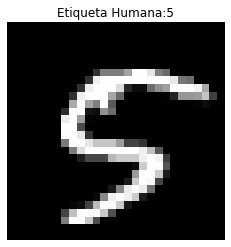

In [12]:
azar=np.random.randint(len(train_data))
print(train_data[azar,:,:,0],'\n')
plt.imshow(train_data[azar,:,:,0],cmap='gray')
plt.title('Etiqueta Humana:'+str(train_label[azar]))
plt.axis('off')
plt.show()

## Preprocesar Datos 

In [13]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    #array = np.reshape(array, (len(array), 28, 28, 1))
    return array

## Añadir Ruido 

In [14]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

## Mostrar Imágenes 

In [15]:
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Utilizar Funciones para el Flujo de Trabajo

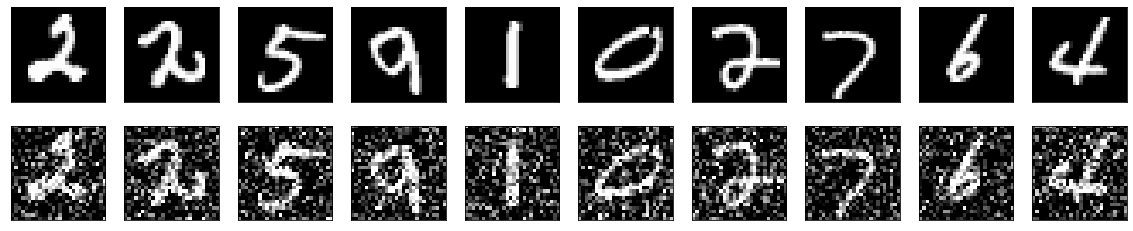

In [16]:
# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Construir Autoenconder Convolucional 

In [17]:
inputs = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(inputs, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        9248  

## Entrenar Autoencoder 

In [18]:
history=autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 [==============================] - 37s 9ms/step - loss: 0.2667 - val_loss: 0.0733
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0725 - val_loss: 0.0694
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0696 - val_loss: 0.0681
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0682 - val_loss: 0.0671
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0674 - val_loss: 0.0665
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0668 - val_loss: 0.0660
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0662 - val_loss: 0.0656
Epoch 8/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0660 - val_loss: 0.0653
Epoch 9/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0656 - val_loss: 0.0650
Epoch 10/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0653 - val_loss: 0.064

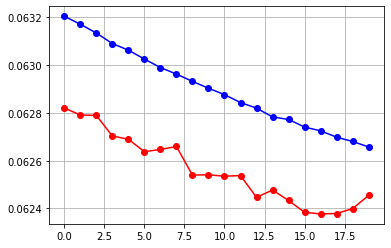

In [25]:
plt.plot(history.history['loss'][-20:],'bo-')
plt.plot(history.history['val_loss'][-20:],'ro-')
plt.grid()
plt.show()

## Mostrar Recuperación 

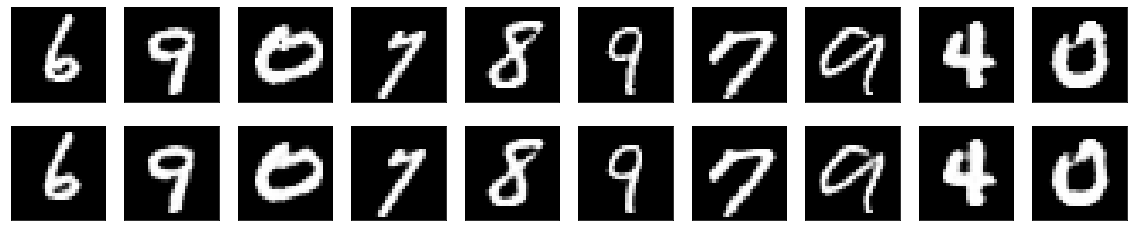

In [26]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

## Entrenar Sobre imágenes ruidosas 

In [27]:
autoencoder2 = Model(inputs, x)
autoencoder2.compile(optimizer="adam", loss="binary_crossentropy")

In [28]:
history2=autoencoder2.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 [==============================] - 5s 9ms/step - loss: 0.1074 - val_loss: 0.0940
Epoch 2/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0939 - val_loss: 0.0917
Epoch 3/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0921 - val_loss: 0.0903
Epoch 4/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0909 - val_loss: 0.0897
Epoch 5/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0900 - val_loss: 0.0888
Epoch 6/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0895 - val_loss: 0.0884
Epoch 7/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0888 - val_loss: 0.0881
Epoch 8/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0886 - val_loss: 0.0877
Epoch 9/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0885 - val_loss: 0.0875
Epoch 10/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0882 - val_lo

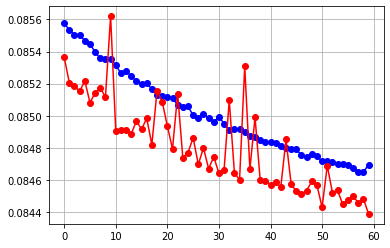

In [35]:
plt.plot(history2.history['loss'][-60:],'bo-')
plt.plot(history2.history['val_loss'][-60:],'ro-')
plt.grid()
plt.show()

## Ver Predicciones

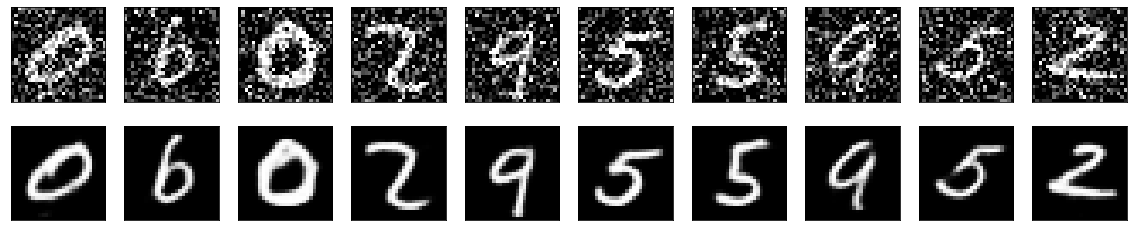

In [30]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)